In [2]:
import os

from typing import Callable
from collections import namedtuple
from copy import deepcopy as dc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from tqdm import tqdm

/tmp/ipykernel_5510/4192602516.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/megamax625/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Данные

In [3]:
ds = datasets.MNIST(
    root='data',
    train=True,
    download=True,

    transform=lambda img: np.array(np.asarray(img).flatten())/256,
    target_transform=lambda x: np.array(
        [1 if i == x else 0 for i in range(10)])
)
train_data_subset = Subset(ds, range(0, 1000))
dl1 = DataLoader(train_data_subset, shuffle=True, batch_size=None)

test_data_subset = Subset(ds, range(1000, 1000+100))
dl2 = DataLoader(test_data_subset, shuffle=True, batch_size=None)

### Слои

In [4]:
class LayerLinear:
    wb: np.ndarray
    inputs: np.ndarray
    optimizer: str
    grad_prev: np.ndarray = None
    H: np.ndarray = None
    wb_prev: np.ndarray = None

    def __init__(self, in_len, out_len, optimizer, perceptron):
        self.wb = np.random.rand(in_len+1, out_len)-0.5
        self.optimizer = optimizer
        self.perceptron = perceptron

    def __repr__(self):
        return f'LayerLinear({self.wb.shape})'

    def __eq__(self, o):
        return id(self) == id(o)

    def forward(self, inputs: np.ndarray):
        self.inputs = np.append(inputs, [1])
        return self.inputs @ self.wb

    def simple_forward(self, inputs: np.ndarray):
        return np.append(inputs, [1]) @ self.wb

    def simple_backward(self, grad):
        return (grad @ self.wb.T)[:-1]

    def backward(self, grad):
        grad_to_ret = (grad @ self.wb.T)[:-1]
        grad_wb = np.reshape(self.inputs, (-1, 1)) @ np.reshape(grad, (1, -1))
        if np.linalg.norm(grad_wb) != 0:
            grad_wb = grad_wb/np.linalg.norm(grad_wb)

        if np.linalg.norm(grad_to_ret) != 0:
            grad_to_ret = grad_to_ret/np.linalg.norm(grad_to_ret)

        if self.optimizer == 'GD':
            d = grad_wb
            
        elif self.optimizer == 'FR':
            if self.grad_prev is None:
                self.grad_prev = grad_wb
                b = 0
            else:
                grad = grad_wb.flatten()
                grad_prev = self.grad_prev.flatten()
                if np.linalg.norm(grad_prev) > 0.00001:
                    b = (np.sum(grad*grad)/np.sum(grad_prev*grad_prev))**2
                else:
                    b = 1
                b = max(min(b, 1), 0)
            d = (grad_wb + b*self.grad_prev)
            self.grad_prev = grad_wb

        elif self.optimizer == 'BFGS':
            if self.H is None:
                self.H = np.identity(len(grad_wb))
                self.grad_prev = np.zeros(grad_wb.shape)
                self.wb_prev = np.zeros(self.wb.shape)

            d = (self.H @ grad_wb)

            y = grad_wb - self.grad_prev
            s = self.wb - self.wb_prev
            W1 = np.eye(len(grad_wb)) - s @ y.T
            self.H = W1 @ self.H @ W1.T

            self.grad_prev = grad_wb
            self.wb_prev = self.wb
        else:
            raise RuntimeError('unknown optimizing method')


        if np.linalg.norm(d) > 0.001:
            d = LR * d / np.linalg.norm(d)

        def calc_special():
            return self.perceptron.calc_for_special_layer(self, self.inputs[:-1])

        old_res_val = calc_special()
        self.wb -= d
        new_res_val = calc_special()
        if new_res_val < old_res_val and abs(new_res_val - old_res_val) > 0.0001:
            while new_res_val < old_res_val and abs(new_res_val - old_res_val) > 0.0001:
                self.wb -= d
                old_res_val = new_res_val
                new_res_val = calc_special()
            self.wb += d

        return grad_to_ret

### Функции активации

In [5]:
import warnings
warnings.filterwarnings("error")

relu = np.vectorize(lambda x: x if x > 0 else 0)
der_relu = np.vectorize(lambda x: 1 if x > 0 else 0)

class LayerReLU:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return relu(inputs)

    def backward(self, grad):
        res = grad * der_relu(self.inputs)
        return res


def sigmoid(x): return 1/(1+np.exp(-x))
def der_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))

class LayerSigmoid:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return sigmoid(inputs)

    def backward(self, grad):
        res = grad * der_sigmoid(self.inputs)
        return res

def softmax(x):
    if np.linalg.norm(x) < 0.001:
        return np.zeros(len(x))
    x = x / np.linalg.norm(x)
    return np.exp(x)/(np.exp(x)).sum() if (np.exp(x)).sum() > 0.01 else np.zeros(len(x))


class LayerSoftmax:
    inputs: np.ndarray

    def forward(self, inputs):
        self.inputs = inputs
        return softmax(inputs)

    def backward(self, grad):
        res = grad * softmax(self.inputs)*(1-softmax(self.inputs))
        return res

### Лосс-функции

In [6]:
LossFunc = namedtuple('LossFunc', ['f', 'df', 'name'])

def mse(x, y): return sum((x-y)**2)/len(x)

def der_mse(x, y):
    res = (x-y)*2/len(x)*-1
    return res / np.sum(np.abs(res))

MSE = LossFunc(mse, der_mse, 'MSE loss')


def cross_entropy(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    return -np.mean(target * np.log(pred))

def der_cross_entropy(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    res = pred - target
    return res / np.linalg.norm(res)

CrossEntropy = LossFunc(cross_entropy, der_cross_entropy, 'Cross-Entropy loss')


def kl(target, pred):
    pred = np.clip(pred, 1e-10, 1 - 1e-10)
    target = np.clip(pred, 1e-10, 1 - 1e-10)
    res = np.mean(target * np.log(target/pred))
    return res

def der_kl(target, pred):
    pred = np.clip(pred, 1e-8, 1 - 1e-8)
    res = pred - target
    return res / np.linalg.norm(res)

KLDiv = LossFunc(kl, der_kl, 'Kullback–Leibler Divergence loss')

### Модель

In [7]:
class Perceptron:
    layers: list
    loss: LossFunc
    last_target: np.ndarray

    def __init__(self, sizes: list[int], loss, optimizer):
        print(sizes)
        self.layers = [x for i, o in zip(sizes, sizes[1:]+[10]) for x in [LayerLinear(i, o, optimizer, self), LayerSigmoid()]] + [LayerSoftmax()]
        self.loss = loss

    def forward(self, inputs):
        res = inputs
        for layer in self.layers:
            res = layer.forward(res)
        return res

    def backward(self, target, pred):
        grad_by_last_layer_outs = self.loss.df(target, pred)
        grad = grad_by_last_layer_outs
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)

    def fit(self, x, y):
        self.last_target = y
        pred = self.forward(x)
        self.backward(y, pred)
        return np.argmax(pred)

    def predict(self, x, y):
        pred = self.forward(x)
        return np.argmax(pred)

    def calc_for_special_layer(self, layer: LayerLinear, inputs: np.ndarray):
        index = self.layers.index(layer)
        res = inputs
        for layer in self.layers[index:]:
            res = layer.forward(res) if type(layer) != LayerLinear else layer.simple_forward(res)
        return self.loss.f(self.last_target, res)

    def fit_special_layer_get_my_grad(self, layer: LayerLinear, inputs: np.ndarray):
        index = self.layers.index(layer)
        res = inputs
        for layer in self.layers[index:]:
            res = layer.forward(res) if type(layer) != LayerLinear else layer.simple_forward(res)
        grad_by_last_layer_outs = self.loss.df(self.last_target, res)
        grad = grad_by_last_layer_outs
        for layer in self.layers[index:][::-1]:
            grad = layer.backward(grad) if type(layer) != LayerLinear else layer.simple_backward(res)
        return grad

### Обучение

In [8]:
def train_epoch(model):
    results = 0
    for X, y in dl1:
        X, y = np.array(X), np.array(y)
        pred = model.fit(X, y)
    for X, y in dl2:
        X, y = np.array(X), np.array(y)
        pred = model.predict(X, y)
        results += (np.argmax(y) == pred)
    return results/len(dl2)

def train_many_epochs(model, N):
    accuracy = []
    for _ in tqdm(range(N)):
        a = train_epoch(model)
        print(a)
        accuracy.append(a)
    return accuracy

def test(loss, optim, lr, epochs, layers=[64]):
    global LR
    LR = lr

    p = Perceptron(
        [784] + layers + [10],
        loss,
        optim
    )
    
    accuracy = train_many_epochs(p, epochs)
    plt.title('Accuracy with ' + loss.name + ' + ' + optim + " optimizer, " + "hidden layers: " + str(layers))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(len(accuracy)), accuracy)
    return accuracy

### Тесты

[784, 64, 10]


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:03<02:51,  3.50s/it]

0.23


  4%|▍         | 2/50 [00:12<05:18,  6.63s/it]

0.27


  6%|▌         | 3/50 [00:19<05:16,  6.74s/it]

0.45


  8%|▊         | 4/50 [00:22<04:12,  5.49s/it]

0.42


 10%|█         | 5/50 [00:28<04:17,  5.72s/it]

0.41


 12%|█▏        | 6/50 [00:34<04:05,  5.58s/it]

0.44


 14%|█▍        | 7/50 [00:38<03:47,  5.30s/it]

0.44


 16%|█▌        | 8/50 [00:43<03:39,  5.22s/it]

0.43


 18%|█▊        | 9/50 [00:53<04:24,  6.45s/it]

0.45


 20%|██        | 10/50 [00:59<04:22,  6.57s/it]

0.48


 22%|██▏       | 11/50 [01:03<03:37,  5.59s/it]

0.52


 24%|██▍       | 12/50 [01:09<03:42,  5.86s/it]

0.53


 26%|██▌       | 13/50 [01:14<03:21,  5.44s/it]

0.52


 28%|██▊       | 14/50 [01:18<03:04,  5.12s/it]

0.53


 30%|███       | 15/50 [01:24<03:02,  5.22s/it]

0.54


 32%|███▏      | 16/50 [01:28<02:50,  5.02s/it]

0.53


 34%|███▍      | 17/50 [01:36<03:17,  5.98s/it]

0.56


 36%|███▌      | 18/50 [01:45<03:32,  6.63s/it]

0.55


 38%|███▊      | 19/50 [01:51<03:26,  6.65s/it]

0.58


 40%|████      | 20/50 [01:56<03:00,  6.03s/it]

0.6


 42%|████▏     | 21/50 [02:00<02:40,  5.55s/it]

0.61


 44%|████▍     | 22/50 [02:06<02:38,  5.66s/it]

0.66


 46%|████▌     | 23/50 [02:14<02:52,  6.39s/it]

0.65


 48%|████▊     | 24/50 [02:19<02:31,  5.84s/it]

0.67


 50%|█████     | 25/50 [02:22<02:07,  5.09s/it]

0.68


 52%|█████▏    | 26/50 [02:27<01:58,  4.94s/it]

0.67


 54%|█████▍    | 27/50 [02:32<01:55,  5.00s/it]

0.68


 56%|█████▌    | 28/50 [02:36<01:45,  4.80s/it]

0.66


 58%|█████▊    | 29/50 [02:40<01:37,  4.64s/it]

0.73


 60%|██████    | 30/50 [02:48<01:48,  5.42s/it]

0.72


 62%|██████▏   | 31/50 [02:54<01:45,  5.58s/it]

0.75


 64%|██████▍   | 32/50 [02:59<01:39,  5.54s/it]

0.76


 66%|██████▌   | 33/50 [03:05<01:37,  5.73s/it]

0.77


 68%|██████▊   | 34/50 [03:11<01:32,  5.75s/it]

0.78


 70%|███████   | 35/50 [03:17<01:25,  5.69s/it]

0.75


 72%|███████▏  | 36/50 [03:21<01:14,  5.35s/it]

0.74


 74%|███████▍  | 37/50 [03:28<01:13,  5.67s/it]

0.77


 76%|███████▌  | 38/50 [03:34<01:11,  5.99s/it]

0.81


 78%|███████▊  | 39/50 [03:38<00:59,  5.43s/it]

0.82


 80%|████████  | 40/50 [03:42<00:47,  4.74s/it]

0.82


 82%|████████▏ | 41/50 [03:45<00:39,  4.37s/it]

0.81


 84%|████████▍ | 42/50 [03:53<00:43,  5.48s/it]

0.81


 86%|████████▌ | 43/50 [03:58<00:36,  5.18s/it]

0.79


 88%|████████▊ | 44/50 [04:02<00:29,  4.96s/it]

0.84


 90%|█████████ | 45/50 [04:07<00:24,  4.89s/it]

0.82


 92%|█████████▏| 46/50 [04:10<00:17,  4.46s/it]

0.83


 94%|█████████▍| 47/50 [04:15<00:13,  4.39s/it]

0.84


 96%|█████████▌| 48/50 [04:17<00:07,  3.83s/it]

0.83


 98%|█████████▊| 49/50 [04:19<00:03,  3.38s/it]

0.85


100%|██████████| 50/50 [04:22<00:00,  5.25s/it]

0.84


0.85

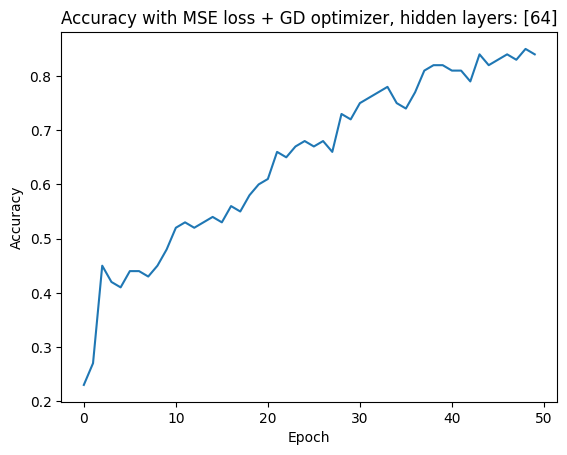

In [9]:
mse_res = test(MSE, "GD", 0.009, 50)
max(mse_res)

[784, 64, 10]


  2%|▏         | 1/50 [00:04<03:39,  4.48s/it]

0.12


  4%|▍         | 2/50 [00:09<03:54,  4.88s/it]

0.17


  6%|▌         | 3/50 [00:14<03:59,  5.09s/it]

0.37


  8%|▊         | 4/50 [00:22<04:37,  6.02s/it]

0.19


 10%|█         | 5/50 [00:29<04:41,  6.25s/it]

0.22


 12%|█▏        | 6/50 [00:33<04:09,  5.67s/it]

0.44


 14%|█▍        | 7/50 [00:39<04:02,  5.65s/it]

0.25


 16%|█▌        | 8/50 [00:42<03:29,  5.00s/it]

0.46


 18%|█▊        | 9/50 [00:49<03:41,  5.41s/it]

0.45


 20%|██        | 10/50 [00:58<04:28,  6.72s/it]

0.36


 22%|██▏       | 11/50 [01:04<04:15,  6.55s/it]

0.45


 24%|██▍       | 12/50 [01:08<03:31,  5.57s/it]

0.51


 26%|██▌       | 13/50 [01:14<03:28,  5.62s/it]

0.53


 28%|██▊       | 14/50 [01:20<03:27,  5.75s/it]

0.47


 30%|███       | 15/50 [01:26<03:28,  5.95s/it]

0.5


 32%|███▏      | 16/50 [01:32<03:19,  5.87s/it]

0.64


 34%|███▍      | 17/50 [01:37<03:03,  5.56s/it]

0.59


 36%|███▌      | 18/50 [01:45<03:23,  6.36s/it]

0.6


 38%|███▊      | 19/50 [01:50<03:11,  6.18s/it]

0.59


 40%|████      | 20/50 [01:57<03:06,  6.21s/it]

0.62


 42%|████▏     | 21/50 [02:03<03:03,  6.34s/it]

0.52


 44%|████▍     | 22/50 [02:13<03:21,  7.18s/it]

0.57


 46%|████▌     | 23/50 [02:21<03:23,  7.55s/it]

0.49


 48%|████▊     | 24/50 [02:28<03:11,  7.36s/it]

0.56


 50%|█████     | 25/50 [02:36<03:06,  7.46s/it]

0.62


 52%|█████▏    | 26/50 [02:44<03:02,  7.60s/it]

0.65


 54%|█████▍    | 27/50 [02:51<02:55,  7.65s/it]

0.64


 56%|█████▌    | 28/50 [03:01<02:59,  8.16s/it]

0.56


 58%|█████▊    | 29/50 [03:10<02:58,  8.48s/it]

0.55


 60%|██████    | 30/50 [03:23<03:17,  9.85s/it]

0.54


 62%|██████▏   | 31/50 [03:36<03:24, 10.76s/it]

0.48


 64%|██████▍   | 32/50 [03:47<03:13, 10.76s/it]

0.49


 66%|██████▌   | 33/50 [03:56<02:57, 10.44s/it]

0.57


 68%|██████▊   | 34/50 [04:06<02:42, 10.16s/it]

0.64


 70%|███████   | 35/50 [04:19<02:45, 11.04s/it]

0.6


 72%|███████▏  | 36/50 [04:31<02:37, 11.24s/it]

0.62


 74%|███████▍  | 37/50 [04:42<02:27, 11.32s/it]

0.64


 76%|███████▌  | 38/50 [04:52<02:11, 10.99s/it]

0.7


 78%|███████▊  | 39/50 [05:03<02:00, 10.98s/it]

0.69


 80%|████████  | 40/50 [05:20<02:06, 12.62s/it]

0.82


 82%|████████▏ | 41/50 [05:47<02:33, 17.02s/it]

0.78


 84%|████████▍ | 42/50 [06:00<02:06, 15.82s/it]

0.78


 86%|████████▌ | 43/50 [06:15<01:48, 15.49s/it]

0.79


 88%|████████▊ | 44/50 [06:27<01:26, 14.40s/it]

0.8


 90%|█████████ | 45/50 [06:39<01:09, 13.87s/it]

0.82


 92%|█████████▏| 46/50 [06:57<01:00, 15.16s/it]

0.81


 94%|█████████▍| 47/50 [07:09<00:42, 14.18s/it]

0.76


 96%|█████████▌| 48/50 [07:17<00:24, 12.25s/it]

0.83


 98%|█████████▊| 49/50 [07:25<00:11, 11.10s/it]

0.8


100%|██████████| 50/50 [07:33<00:00,  9.07s/it]

0.82


0.83

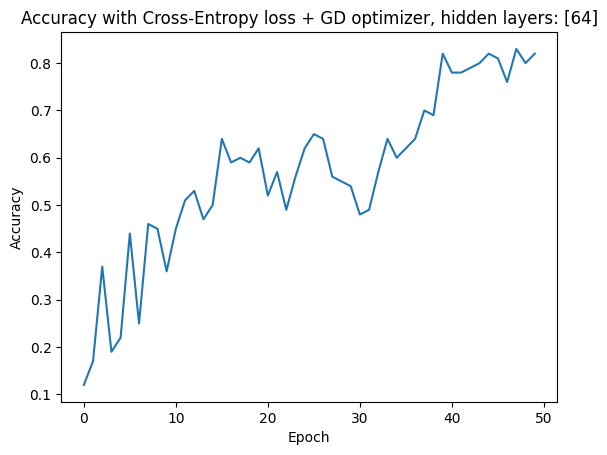

In [10]:
ce_res = test(CrossEntropy, "GD", 0.005, 50)
max(ce_res)

[784, 64, 10]


  2%|▏         | 1/50 [00:04<03:51,  4.73s/it]

0.16


  4%|▍         | 2/50 [00:09<03:53,  4.86s/it]

0.16


  6%|▌         | 3/50 [00:13<03:26,  4.39s/it]

0.16


  8%|▊         | 4/50 [00:25<05:37,  7.34s/it]

0.2


 10%|█         | 5/50 [00:33<05:46,  7.71s/it]

0.34


 12%|█▏        | 6/50 [00:42<05:53,  8.04s/it]

0.44


 14%|█▍        | 7/50 [00:51<05:54,  8.25s/it]

0.56


 16%|█▌        | 8/50 [00:58<05:31,  7.89s/it]

0.62


 18%|█▊        | 9/50 [01:04<05:00,  7.32s/it]

0.6


 20%|██        | 10/50 [01:11<04:57,  7.43s/it]

0.6


 22%|██▏       | 11/50 [01:18<04:39,  7.18s/it]

0.6


 24%|██▍       | 12/50 [01:29<05:13,  8.26s/it]

0.59


 26%|██▌       | 13/50 [01:33<04:23,  7.12s/it]

0.6


 28%|██▊       | 14/50 [01:38<03:47,  6.32s/it]

0.6


 30%|███       | 15/50 [01:45<03:47,  6.49s/it]

0.61


 32%|███▏      | 16/50 [01:49<03:18,  5.85s/it]

0.62


 34%|███▍      | 17/50 [01:53<02:58,  5.40s/it]

0.62


 36%|███▌      | 18/50 [02:01<03:13,  6.05s/it]

0.65


 38%|███▊      | 19/50 [02:06<02:54,  5.63s/it]

0.63


 40%|████      | 20/50 [02:10<02:38,  5.29s/it]

0.64


 42%|████▏     | 21/50 [02:16<02:38,  5.48s/it]

0.69


 44%|████▍     | 22/50 [02:23<02:42,  5.80s/it]

0.67


 46%|████▌     | 23/50 [02:28<02:31,  5.61s/it]

0.7


 48%|████▊     | 24/50 [02:32<02:13,  5.15s/it]

0.69


 50%|█████     | 25/50 [02:36<02:02,  4.91s/it]

0.7


 52%|█████▏    | 26/50 [02:40<01:49,  4.57s/it]

0.69


 54%|█████▍    | 27/50 [02:43<01:35,  4.17s/it]

0.71


 56%|█████▌    | 28/50 [02:46<01:22,  3.73s/it]

0.71


 58%|█████▊    | 29/50 [02:49<01:14,  3.57s/it]

0.71


 60%|██████    | 30/50 [02:54<01:20,  4.02s/it]

0.71


 62%|██████▏   | 31/50 [02:58<01:14,  3.92s/it]

0.72


 64%|██████▍   | 32/50 [03:03<01:15,  4.18s/it]

0.73


 66%|██████▌   | 33/50 [03:08<01:16,  4.51s/it]

0.73


 68%|██████▊   | 34/50 [03:14<01:18,  4.92s/it]

0.73


 70%|███████   | 35/50 [03:19<01:15,  5.06s/it]

0.74


 72%|███████▏  | 36/50 [03:25<01:14,  5.33s/it]

0.74


 74%|███████▍  | 37/50 [03:30<01:06,  5.11s/it]

0.74


 76%|███████▌  | 38/50 [03:33<00:56,  4.68s/it]

0.73


 78%|███████▊  | 39/50 [03:37<00:47,  4.34s/it]

0.73


 80%|████████  | 40/50 [03:42<00:46,  4.61s/it]

0.73


 82%|████████▏ | 41/50 [03:48<00:46,  5.12s/it]

0.73


 84%|████████▍ | 42/50 [03:54<00:41,  5.22s/it]

0.72


 86%|████████▌ | 43/50 [03:59<00:36,  5.20s/it]

0.73


 88%|████████▊ | 44/50 [04:05<00:32,  5.38s/it]

0.71


 90%|█████████ | 45/50 [04:11<00:27,  5.48s/it]

0.7


 92%|█████████▏| 46/50 [04:15<00:20,  5.15s/it]

0.7


 94%|█████████▍| 47/50 [04:19<00:14,  4.69s/it]

0.7


 96%|█████████▌| 48/50 [04:22<00:08,  4.42s/it]

0.69


 98%|█████████▊| 49/50 [04:28<00:04,  4.65s/it]

0.68


100%|██████████| 50/50 [04:31<00:00,  5.43s/it]

0.69


0.74

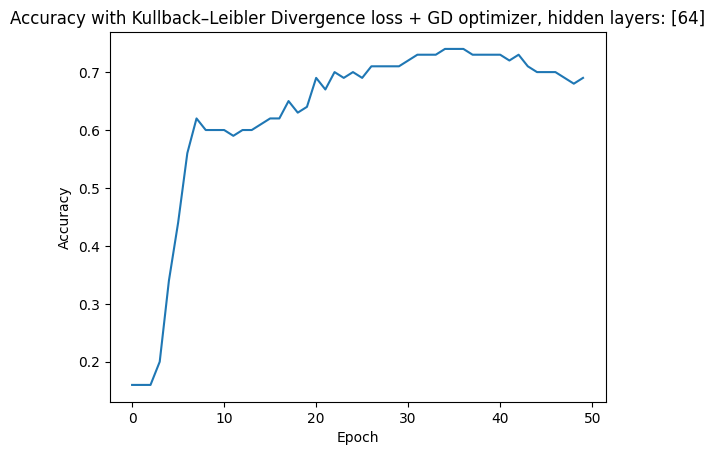

In [11]:
kld_res = test(KLDiv, "GD", 0.011, 50)
max(kld_res)

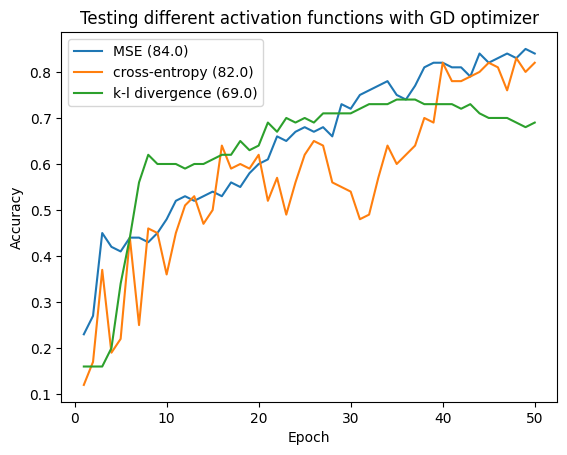

In [12]:
plt.plot(range(1, 51), mse_res, label=f'MSE ({np.round(mse_res[-1] * 100, 2)})')
plt.plot(range(1, 51), ce_res, label=f'cross-entropy ({np.round(ce_res[-1] * 100, 2)})')
plt.plot(range(1, 51), kld_res, label=f'k-l divergence ({np.round(kld_res[-1] * 100, 2)})')

plt.title('Testing different activation functions with GD optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[784, 64, 10]


  2%|▏         | 1/50 [00:04<03:54,  4.79s/it]

0.26


  4%|▍         | 2/50 [00:11<04:36,  5.77s/it]

0.23


  6%|▌         | 3/50 [00:15<03:49,  4.89s/it]

0.35


  8%|▊         | 4/50 [00:20<03:57,  5.17s/it]

0.29


 10%|█         | 5/50 [00:24<03:26,  4.59s/it]

0.31


 12%|█▏        | 6/50 [00:27<03:00,  4.10s/it]

0.35


 14%|█▍        | 7/50 [00:33<03:25,  4.77s/it]

0.43


 16%|█▌        | 8/50 [00:36<02:59,  4.27s/it]

0.45


 18%|█▊        | 9/50 [00:42<03:17,  4.83s/it]

0.46


 20%|██        | 10/50 [00:49<03:34,  5.35s/it]

0.47


 22%|██▏       | 11/50 [00:57<04:01,  6.20s/it]

0.47


 24%|██▍       | 12/50 [01:04<04:08,  6.54s/it]

0.44


 26%|██▌       | 13/50 [01:11<04:08,  6.73s/it]

0.4


 28%|██▊       | 14/50 [01:20<04:25,  7.38s/it]

0.45


 30%|███       | 15/50 [01:28<04:17,  7.37s/it]

0.41


 32%|███▏      | 16/50 [01:36<04:15,  7.53s/it]

0.41


 34%|███▍      | 17/50 [01:44<04:15,  7.75s/it]

0.34


 36%|███▌      | 18/50 [01:53<04:17,  8.05s/it]

0.38


 38%|███▊      | 19/50 [02:01<04:12,  8.13s/it]

0.38


 40%|████      | 20/50 [02:07<03:43,  7.45s/it]

0.4


 42%|████▏     | 21/50 [02:14<03:36,  7.48s/it]

0.4


 44%|████▍     | 22/50 [02:22<03:33,  7.63s/it]

0.42


 46%|████▌     | 23/50 [02:28<03:12,  7.15s/it]

0.39


 48%|████▊     | 24/50 [02:35<03:01,  6.97s/it]

0.42


 50%|█████     | 25/50 [02:42<02:59,  7.16s/it]

0.44


 52%|█████▏    | 26/50 [02:49<02:44,  6.85s/it]

0.39


 54%|█████▍    | 27/50 [02:53<02:22,  6.18s/it]

0.34


 56%|█████▌    | 28/50 [03:02<02:30,  6.85s/it]

0.35


 58%|█████▊    | 29/50 [03:11<02:41,  7.70s/it]

0.39


 60%|██████    | 30/50 [03:21<02:44,  8.24s/it]

0.37


 62%|██████▏   | 31/50 [03:28<02:32,  8.04s/it]

0.36


 64%|██████▍   | 32/50 [03:35<02:16,  7.56s/it]

0.36


 66%|██████▌   | 33/50 [03:44<02:19,  8.18s/it]

0.35


 68%|██████▊   | 34/50 [03:54<02:15,  8.45s/it]

0.35


 70%|███████   | 35/50 [04:00<01:58,  7.87s/it]

0.33


 72%|███████▏  | 36/50 [04:10<01:57,  8.41s/it]

0.37


 74%|███████▍  | 37/50 [04:21<02:02,  9.40s/it]

0.46


 76%|███████▌  | 38/50 [04:28<01:44,  8.69s/it]

0.35


 78%|███████▊  | 39/50 [04:37<01:34,  8.62s/it]

0.42


 80%|████████  | 40/50 [04:44<01:20,  8.07s/it]

0.34


 82%|████████▏ | 41/50 [04:56<01:24,  9.44s/it]

0.37


 84%|████████▍ | 42/50 [05:10<01:25, 10.64s/it]

0.43


 86%|████████▌ | 43/50 [05:26<01:27, 12.45s/it]

0.46


 88%|████████▊ | 44/50 [05:40<01:16, 12.83s/it]

0.48


 90%|█████████ | 45/50 [05:53<01:04, 12.86s/it]

0.41


 92%|█████████▏| 46/50 [06:05<00:50, 12.51s/it]

0.41


 94%|█████████▍| 47/50 [06:15<00:35, 11.90s/it]

0.43


 96%|█████████▌| 48/50 [06:28<00:24, 12.01s/it]

0.46


 98%|█████████▊| 49/50 [06:37<00:11, 11.15s/it]

0.45


100%|██████████| 50/50 [06:46<00:00,  8.13s/it]

0.47


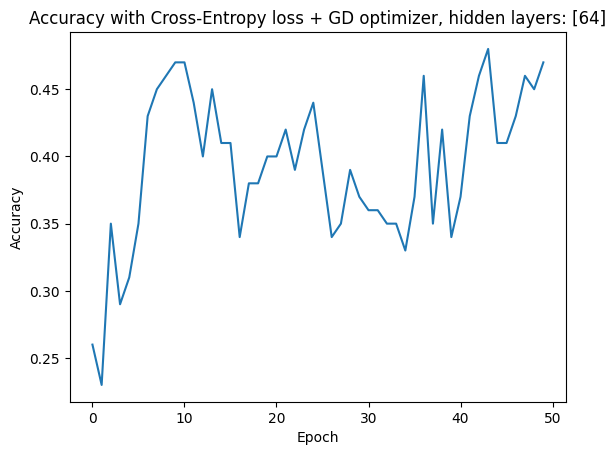

In [13]:
gd_res = test(CrossEntropy, "GD", 0.005, 50)

In [14]:
fr_res = test(CrossEntropy, "FR", 0.005, 50)

[784, 64, 10]


  2%|▏         | 1/50 [00:08<07:10,  8.79s/it]

0.14


  4%|▍         | 2/50 [00:14<05:35,  6.98s/it]

0.38


  6%|▌         | 3/50 [00:18<04:33,  5.82s/it]

0.36


  8%|▊         | 4/50 [00:24<04:31,  5.90s/it]

0.48


 10%|█         | 5/50 [00:31<04:40,  6.23s/it]

0.41


 12%|█▏        | 6/50 [00:38<04:42,  6.43s/it]

0.5


 14%|█▍        | 7/50 [00:48<05:25,  7.58s/it]

0.34


 16%|█▌        | 8/50 [01:02<06:44,  9.64s/it]

0.56


 18%|█▊        | 9/50 [01:14<07:08, 10.45s/it]

0.48


 20%|██        | 10/50 [01:31<08:20, 12.50s/it]

0.6


 22%|██▏       | 11/50 [01:49<09:08, 14.07s/it]

0.64


 24%|██▍       | 12/50 [02:06<09:24, 14.85s/it]

0.72


 26%|██▌       | 13/50 [02:17<08:29, 13.76s/it]

0.78


 28%|██▊       | 14/50 [02:25<07:10, 11.97s/it]

0.57


 30%|███       | 15/50 [02:34<06:26, 11.03s/it]

0.73


 32%|███▏      | 16/50 [02:42<05:49, 10.28s/it]

0.7


 34%|███▍      | 17/50 [02:51<05:23,  9.79s/it]

0.78


 36%|███▌      | 18/50 [02:59<04:53,  9.17s/it]

0.75


 38%|███▊      | 19/50 [03:06<04:27,  8.64s/it]

0.75


 40%|████      | 20/50 [03:12<03:53,  7.78s/it]

0.77


 42%|████▏     | 21/50 [03:18<03:28,  7.20s/it]

0.79


 44%|████▍     | 22/50 [03:23<03:10,  6.80s/it]

0.82


 46%|████▌     | 23/50 [03:29<02:56,  6.53s/it]

0.78


 48%|████▊     | 24/50 [03:35<02:41,  6.21s/it]

0.77


 50%|█████     | 25/50 [03:40<02:24,  5.78s/it]

0.78


 52%|█████▏    | 26/50 [03:47<02:27,  6.14s/it]

0.8


 54%|█████▍    | 27/50 [03:57<02:51,  7.48s/it]

0.79


 56%|█████▌    | 28/50 [04:04<02:41,  7.36s/it]

0.79


 58%|█████▊    | 29/50 [04:11<02:30,  7.17s/it]

0.79


 58%|█████▊    | 29/50 [04:15<03:05,  8.82s/it]


KeyboardInterrupt: 

[784, 64, 10]


  2%|▏         | 1/50 [00:30<24:34, 30.09s/it]

0.22


  4%|▍         | 2/50 [00:58<23:26, 29.30s/it]

0.21


  6%|▌         | 3/50 [01:28<22:58, 29.33s/it]

0.25


  8%|▊         | 4/50 [01:58<22:45, 29.68s/it]

0.38


 10%|█         | 5/50 [02:28<22:23, 29.86s/it]

0.36


 12%|█▏        | 6/50 [02:58<21:55, 29.90s/it]

0.46


 14%|█▍        | 7/50 [03:32<22:24, 31.26s/it]

0.44


 16%|█▌        | 8/50 [04:06<22:21, 31.95s/it]

0.41


 18%|█▊        | 9/50 [04:41<22:32, 32.98s/it]

0.41


 20%|██        | 10/50 [05:14<22:03, 33.09s/it]

0.46


 22%|██▏       | 11/50 [05:48<21:36, 33.25s/it]

0.48


 24%|██▍       | 12/50 [06:21<21:07, 33.35s/it]

0.53


 26%|██▌       | 13/50 [06:54<20:31, 33.29s/it]

0.53


 28%|██▊       | 14/50 [07:28<20:02, 33.40s/it]

0.56


 30%|███       | 15/50 [08:01<19:21, 33.19s/it]

0.44


 32%|███▏      | 16/50 [08:35<19:01, 33.56s/it]

0.38


 34%|███▍      | 17/50 [09:15<19:31, 35.49s/it]

0.4


 36%|███▌      | 18/50 [09:55<19:36, 36.75s/it]

0.5


 38%|███▊      | 19/50 [10:33<19:10, 37.11s/it]

0.6


 40%|████      | 20/50 [11:11<18:41, 37.39s/it]

0.59


 42%|████▏     | 21/50 [11:48<18:03, 37.37s/it]

0.49


 44%|████▍     | 22/50 [12:25<17:24, 37.31s/it]

0.62


 46%|████▌     | 23/50 [13:03<16:50, 37.44s/it]

0.7


 48%|████▊     | 24/50 [13:43<16:29, 38.07s/it]

0.69


 50%|█████     | 25/50 [14:21<15:54, 38.20s/it]

0.65


 52%|█████▏    | 26/50 [15:00<15:18, 38.29s/it]

0.69


 54%|█████▍    | 27/50 [15:38<14:37, 38.17s/it]

0.7


 56%|█████▌    | 28/50 [16:15<13:56, 38.00s/it]

0.67


 58%|█████▊    | 29/50 [16:53<13:15, 37.88s/it]

0.72


 60%|██████    | 30/50 [17:29<12:28, 37.41s/it]

0.73


 62%|██████▏   | 31/50 [18:06<11:46, 37.19s/it]

0.62


 64%|██████▍   | 32/50 [18:43<11:09, 37.19s/it]

0.61


 66%|██████▌   | 33/50 [19:19<10:24, 36.72s/it]

0.67


 68%|██████▊   | 34/50 [19:54<09:43, 36.47s/it]

0.73


 70%|███████   | 35/50 [20:30<09:04, 36.32s/it]

0.65


 72%|███████▏  | 36/50 [21:05<08:21, 35.83s/it]

0.74


 74%|███████▍  | 37/50 [21:41<07:45, 35.82s/it]

0.73


 76%|███████▌  | 38/50 [22:15<07:04, 35.36s/it]

0.67


 78%|███████▊  | 39/50 [22:51<06:28, 35.36s/it]

0.63


 80%|████████  | 40/50 [23:25<05:52, 35.23s/it]

0.71


 82%|████████▏ | 41/50 [24:00<05:15, 35.06s/it]

0.77


 84%|████████▍ | 42/50 [24:34<04:36, 34.62s/it]

0.75


 86%|████████▌ | 43/50 [25:08<04:01, 34.45s/it]

0.71


 88%|████████▊ | 44/50 [25:42<03:26, 34.37s/it]

0.69


 90%|█████████ | 45/50 [26:15<02:49, 33.90s/it]

0.76


 92%|█████████▏| 46/50 [26:48<02:14, 33.75s/it]

0.75


 94%|█████████▍| 47/50 [27:21<01:40, 33.40s/it]

0.75


 96%|█████████▌| 48/50 [27:51<01:05, 32.52s/it]

0.74


 98%|█████████▊| 49/50 [28:21<00:31, 31.69s/it]

0.72


100%|██████████| 50/50 [28:52<00:00, 34.64s/it]

0.74


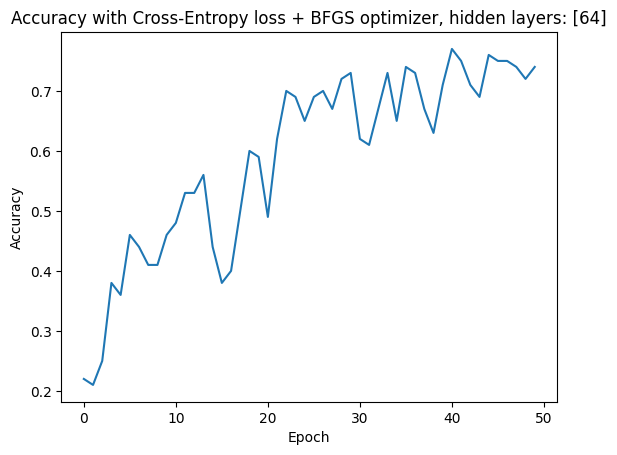

In [ ]:
bfgs_res = test(CrossEntropy, "BFGS", 0.009, 50)

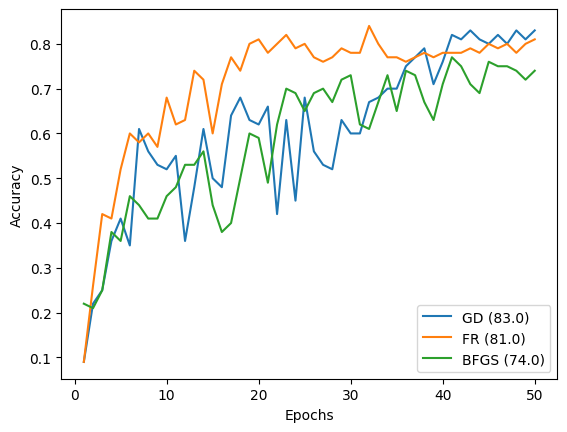

In [ ]:
plt.plot(range(1, 51), gd_res, label=f'GD ({np.round(gd_res[-1] * 100, 2)})')
plt.plot(range(1, 51), fr_res, label=f'FR ({np.round(fr_res[-1] * 100, 2)})')
plt.plot(range(1, 51), bfgs_res, label=f'BFGS ({np.round(bfgs_res[-1] * 100, 2)})')

plt.title('Testing different optimizations with CrossEntropy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

[784, 64, 64, 64, 10]


  2%|▏         | 1/50 [00:03<03:15,  4.00s/it]

0.16


  4%|▍         | 2/50 [00:07<02:59,  3.73s/it]

0.17


  6%|▌         | 3/50 [00:10<02:48,  3.60s/it]

0.26


  8%|▊         | 4/50 [00:14<02:43,  3.56s/it]

0.3


 10%|█         | 5/50 [00:17<02:37,  3.50s/it]

0.33


 12%|█▏        | 6/50 [00:21<02:35,  3.54s/it]

0.32


 14%|█▍        | 7/50 [00:25<02:35,  3.61s/it]

0.25


 16%|█▌        | 8/50 [00:28<02:30,  3.59s/it]

0.25


 18%|█▊        | 9/50 [00:32<02:33,  3.74s/it]

0.36


 20%|██        | 10/50 [00:36<02:30,  3.75s/it]

0.41


 22%|██▏       | 11/50 [00:40<02:25,  3.74s/it]

0.41


 24%|██▍       | 12/50 [00:44<02:23,  3.77s/it]

0.42


 26%|██▌       | 13/50 [00:47<02:19,  3.77s/it]

0.41


 28%|██▊       | 14/50 [00:51<02:17,  3.82s/it]

0.42


 30%|███       | 15/50 [00:55<02:14,  3.84s/it]

0.43


 32%|███▏      | 16/50 [00:59<02:10,  3.84s/it]

0.49


 34%|███▍      | 17/50 [01:03<02:09,  3.92s/it]

0.5


 36%|███▌      | 18/50 [01:07<02:06,  3.96s/it]

0.52


 38%|███▊      | 19/50 [01:11<02:03,  3.97s/it]

0.51


 40%|████      | 20/50 [01:15<01:59,  3.97s/it]

0.52


 42%|████▏     | 21/50 [01:19<01:56,  4.00s/it]

0.54


 44%|████▍     | 22/50 [01:23<01:52,  4.02s/it]

0.53


 46%|████▌     | 23/50 [01:27<01:48,  4.02s/it]

0.54


 48%|████▊     | 24/50 [01:32<01:48,  4.16s/it]

0.54


 50%|█████     | 25/50 [01:36<01:44,  4.18s/it]

0.56


 52%|█████▏    | 26/50 [01:40<01:40,  4.18s/it]

0.57


 54%|█████▍    | 27/50 [01:45<01:37,  4.24s/it]

0.54


 56%|█████▌    | 28/50 [01:49<01:35,  4.34s/it]

0.57


 58%|█████▊    | 29/50 [01:54<01:31,  4.37s/it]

0.55


 60%|██████    | 30/50 [01:58<01:27,  4.38s/it]

0.6


 62%|██████▏   | 31/50 [02:03<01:23,  4.41s/it]

0.56


 64%|██████▍   | 32/50 [02:07<01:20,  4.47s/it]

0.56


 66%|██████▌   | 33/50 [02:12<01:16,  4.48s/it]

0.59


 68%|██████▊   | 34/50 [02:16<01:12,  4.51s/it]

0.62


 70%|███████   | 35/50 [02:21<01:06,  4.46s/it]

0.65


 72%|███████▏  | 36/50 [02:25<01:01,  4.38s/it]

0.6


 74%|███████▍  | 37/50 [02:29<00:56,  4.38s/it]

0.66


 76%|███████▌  | 38/50 [02:34<00:53,  4.49s/it]

0.66


 78%|███████▊  | 39/50 [02:38<00:48,  4.38s/it]

0.6


 80%|████████  | 40/50 [02:42<00:43,  4.36s/it]

0.66


 82%|████████▏ | 41/50 [02:47<00:38,  4.30s/it]

0.65


 84%|████████▍ | 42/50 [02:51<00:34,  4.30s/it]

0.64


 86%|████████▌ | 43/50 [02:55<00:29,  4.25s/it]

0.66


 88%|████████▊ | 44/50 [02:59<00:25,  4.21s/it]

0.64


 90%|█████████ | 45/50 [03:03<00:21,  4.20s/it]

0.66


 92%|█████████▏| 46/50 [03:07<00:16,  4.16s/it]

0.67


 94%|█████████▍| 47/50 [03:11<00:12,  4.16s/it]

0.65


 96%|█████████▌| 48/50 [03:15<00:08,  4.10s/it]

0.66


 98%|█████████▊| 49/50 [03:19<00:04,  4.04s/it]

0.67


100%|██████████| 50/50 [03:23<00:00,  4.07s/it]

0.66


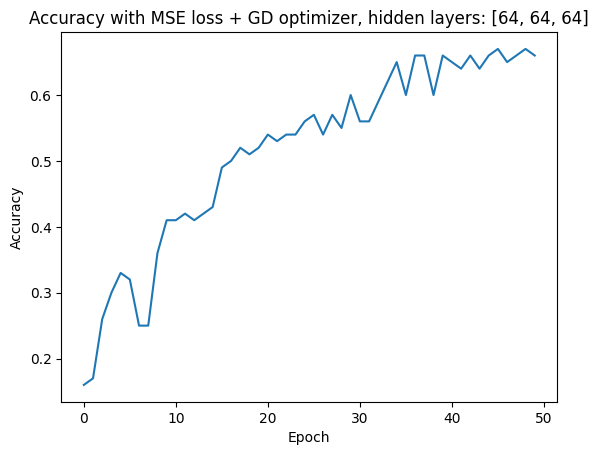

In [ ]:
layers_res_1 = test(MSE, "GD", 0.008, 50, [64, 64, 64])

[784, 64, 64, 10]


  2%|▏         | 1/50 [00:03<02:40,  3.27s/it]

0.12


  4%|▍         | 2/50 [00:06<02:28,  3.09s/it]

0.08


  6%|▌         | 3/50 [00:09<02:25,  3.09s/it]

0.23


  8%|▊         | 4/50 [00:12<02:21,  3.07s/it]

0.35


 10%|█         | 5/50 [00:15<02:17,  3.05s/it]

0.39


 12%|█▏        | 6/50 [00:18<02:12,  3.02s/it]

0.39


 14%|█▍        | 7/50 [00:21<02:09,  3.00s/it]

0.41


 16%|█▌        | 8/50 [00:24<02:05,  3.00s/it]

0.4


 18%|█▊        | 9/50 [00:27<02:03,  3.01s/it]

0.41


 20%|██        | 10/50 [00:30<02:00,  3.02s/it]

0.46


 22%|██▏       | 11/50 [00:33<01:59,  3.06s/it]

0.48


 24%|██▍       | 12/50 [00:36<01:57,  3.10s/it]

0.49


 26%|██▌       | 13/50 [00:40<01:58,  3.20s/it]

0.54


 28%|██▊       | 14/50 [00:43<01:57,  3.27s/it]

0.55


 30%|███       | 15/50 [00:46<01:54,  3.27s/it]

0.55


 32%|███▏      | 16/50 [00:50<01:51,  3.27s/it]

0.54


 34%|███▍      | 17/50 [00:53<01:47,  3.26s/it]

0.61


 36%|███▌      | 18/50 [00:56<01:44,  3.27s/it]

0.62


 38%|███▊      | 19/50 [00:59<01:40,  3.26s/it]

0.58


 40%|████      | 20/50 [01:03<01:37,  3.26s/it]

0.58


 42%|████▏     | 21/50 [01:06<01:34,  3.27s/it]

0.62


 44%|████▍     | 22/50 [01:10<01:36,  3.45s/it]

0.61


 46%|████▌     | 23/50 [01:13<01:31,  3.38s/it]

0.61


 48%|████▊     | 24/50 [01:16<01:27,  3.36s/it]

0.59


 50%|█████     | 25/50 [01:20<01:26,  3.44s/it]

0.62


 52%|█████▏    | 26/50 [01:23<01:22,  3.46s/it]

0.62


 54%|█████▍    | 27/50 [01:27<01:19,  3.46s/it]

0.63


 56%|█████▌    | 28/50 [01:30<01:16,  3.46s/it]

0.61


 58%|█████▊    | 29/50 [01:34<01:12,  3.46s/it]

0.66


 60%|██████    | 30/50 [01:37<01:08,  3.43s/it]

0.65


 62%|██████▏   | 31/50 [01:40<01:04,  3.39s/it]

0.64


 64%|██████▍   | 32/50 [01:44<01:02,  3.45s/it]

0.65


 66%|██████▌   | 33/50 [01:48<00:58,  3.45s/it]

0.67


 68%|██████▊   | 34/50 [01:51<00:54,  3.40s/it]

0.64


 70%|███████   | 35/50 [01:54<00:50,  3.36s/it]

0.63


 72%|███████▏  | 36/50 [01:57<00:46,  3.34s/it]

0.66


 74%|███████▍  | 37/50 [02:01<00:42,  3.31s/it]

0.65


 76%|███████▌  | 38/50 [02:04<00:39,  3.29s/it]

0.66


 78%|███████▊  | 39/50 [02:07<00:35,  3.26s/it]

0.67


 80%|████████  | 40/50 [02:11<00:33,  3.37s/it]

0.67


 82%|████████▏ | 41/50 [02:14<00:30,  3.34s/it]

0.66


 84%|████████▍ | 42/50 [02:17<00:26,  3.31s/it]

0.66


 86%|████████▌ | 43/50 [02:20<00:22,  3.25s/it]

0.67


 88%|████████▊ | 44/50 [02:24<00:19,  3.29s/it]

0.66


 90%|█████████ | 45/50 [02:27<00:17,  3.40s/it]

0.66


 92%|█████████▏| 46/50 [02:30<00:13,  3.32s/it]

0.65


 94%|█████████▍| 47/50 [02:34<00:09,  3.28s/it]

0.65


 96%|█████████▌| 48/50 [02:37<00:06,  3.24s/it]

0.65


 98%|█████████▊| 49/50 [02:40<00:03,  3.23s/it]

0.66


100%|██████████| 50/50 [02:43<00:00,  3.27s/it]

0.65


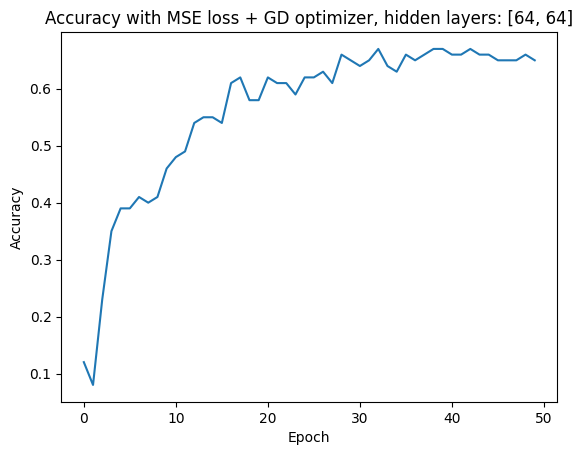

In [ ]:
layers_res_2 = test(MSE, "GD", 0.009, 50, [64, 64])

[784, 64, 10]


  2%|▏         | 1/50 [00:02<02:09,  2.65s/it]

0.15


  4%|▍         | 2/50 [00:05<02:03,  2.58s/it]

0.24


  6%|▌         | 3/50 [00:07<01:59,  2.54s/it]

0.28


  8%|▊         | 4/50 [00:10<01:54,  2.48s/it]

0.34


 10%|█         | 5/50 [00:12<01:51,  2.47s/it]

0.38


 12%|█▏        | 6/50 [00:15<01:49,  2.49s/it]

0.42


 14%|█▍        | 7/50 [00:17<01:45,  2.45s/it]

0.43


 16%|█▌        | 8/50 [00:19<01:43,  2.47s/it]

0.49


 18%|█▊        | 9/50 [00:22<01:42,  2.51s/it]

0.45


 20%|██        | 10/50 [00:25<01:45,  2.64s/it]

0.46


 22%|██▏       | 11/50 [00:28<01:42,  2.64s/it]

0.5


 24%|██▍       | 12/50 [00:30<01:40,  2.65s/it]

0.52


 26%|██▌       | 13/50 [00:33<01:38,  2.66s/it]

0.53


 28%|██▊       | 14/50 [00:36<01:36,  2.69s/it]

0.55


 30%|███       | 15/50 [00:38<01:35,  2.72s/it]

0.59


 32%|███▏      | 16/50 [00:41<01:32,  2.73s/it]

0.57


 34%|███▍      | 17/50 [00:44<01:30,  2.74s/it]

0.55


 36%|███▌      | 18/50 [00:47<01:28,  2.78s/it]

0.58


 38%|███▊      | 19/50 [00:50<01:27,  2.82s/it]

0.6


 40%|████      | 20/50 [00:53<01:26,  2.88s/it]

0.55


 42%|████▏     | 21/50 [00:56<01:24,  2.91s/it]

0.64


 44%|████▍     | 22/50 [00:59<01:23,  2.99s/it]

0.65


 46%|████▌     | 23/50 [01:02<01:20,  2.97s/it]

0.68


 48%|████▊     | 24/50 [01:05<01:18,  3.01s/it]

0.69


 50%|█████     | 25/50 [01:08<01:15,  3.04s/it]

0.7


 52%|█████▏    | 26/50 [01:11<01:13,  3.06s/it]

0.69


 54%|█████▍    | 27/50 [01:14<01:11,  3.09s/it]

0.71


 56%|█████▌    | 28/50 [01:17<01:07,  3.07s/it]

0.72


 58%|█████▊    | 29/50 [01:20<01:04,  3.06s/it]

0.75


 60%|██████    | 30/50 [01:24<01:01,  3.09s/it]

0.78


 62%|██████▏   | 31/50 [01:27<01:00,  3.20s/it]

0.77


 64%|██████▍   | 32/50 [01:30<00:58,  3.26s/it]

0.77


 66%|██████▌   | 33/50 [01:34<00:54,  3.22s/it]

0.79


 68%|██████▊   | 34/50 [01:37<00:50,  3.17s/it]

0.78


 70%|███████   | 35/50 [01:40<00:47,  3.14s/it]

0.79


 72%|███████▏  | 36/50 [01:43<00:43,  3.11s/it]

0.78


 74%|███████▍  | 37/50 [01:46<00:39,  3.07s/it]

0.77


 76%|███████▌  | 38/50 [01:49<00:36,  3.01s/it]

0.78


 78%|███████▊  | 39/50 [01:52<00:32,  3.00s/it]

0.79


 80%|████████  | 40/50 [01:54<00:29,  2.96s/it]

0.81


 82%|████████▏ | 41/50 [01:57<00:26,  2.91s/it]

0.81


 84%|████████▍ | 42/50 [02:00<00:23,  2.92s/it]

0.83


 86%|████████▌ | 43/50 [02:03<00:20,  2.89s/it]

0.79


 88%|████████▊ | 44/50 [02:06<00:17,  2.85s/it]

0.79


 90%|█████████ | 45/50 [02:09<00:14,  2.83s/it]

0.8


 92%|█████████▏| 46/50 [02:11<00:11,  2.79s/it]

0.81


 94%|█████████▍| 47/50 [02:14<00:08,  2.79s/it]

0.78


 96%|█████████▌| 48/50 [02:17<00:05,  2.81s/it]

0.82


 98%|█████████▊| 49/50 [02:19<00:02,  2.74s/it]

0.8


100%|██████████| 50/50 [02:22<00:00,  2.85s/it]

0.81


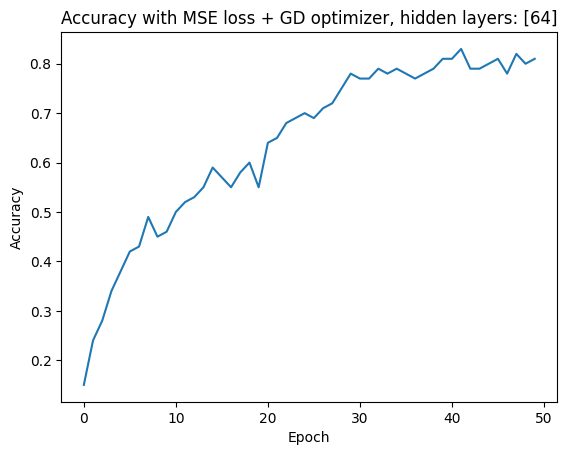

In [ ]:
layers_res_3 = test(MSE, "GD", 0.0088, 50, [64])

[784, 128, 64, 10]


  2%|▏         | 1/50 [00:04<03:16,  4.02s/it]

0.1


  4%|▍         | 2/50 [00:07<03:01,  3.78s/it]

0.24


  6%|▌         | 3/50 [00:11<02:54,  3.71s/it]

0.27


  8%|▊         | 4/50 [00:14<02:49,  3.68s/it]

0.32


 10%|█         | 5/50 [00:18<02:44,  3.65s/it]

0.36


 12%|█▏        | 6/50 [00:22<02:38,  3.61s/it]

0.42


 14%|█▍        | 7/50 [00:25<02:34,  3.59s/it]

0.46


 16%|█▌        | 8/50 [00:29<02:30,  3.58s/it]

0.51


 18%|█▊        | 9/50 [00:32<02:28,  3.62s/it]

0.55


 20%|██        | 10/50 [00:36<02:25,  3.65s/it]

0.52


 22%|██▏       | 11/50 [00:40<02:23,  3.69s/it]

0.54


 24%|██▍       | 12/50 [00:44<02:21,  3.72s/it]

0.51


 26%|██▌       | 13/50 [00:48<02:19,  3.78s/it]

0.53


 28%|██▊       | 14/50 [00:51<02:16,  3.79s/it]

0.54


 30%|███       | 15/50 [00:55<02:14,  3.83s/it]

0.53


 32%|███▏      | 16/50 [00:59<02:13,  3.91s/it]

0.54


 34%|███▍      | 17/50 [01:04<02:14,  4.06s/it]

0.51


 36%|███▌      | 18/50 [01:08<02:10,  4.08s/it]

0.55


 38%|███▊      | 19/50 [01:13<02:13,  4.32s/it]

0.55


 40%|████      | 20/50 [01:17<02:10,  4.36s/it]

0.64


 42%|████▏     | 21/50 [01:22<02:08,  4.42s/it]

0.63


 44%|████▍     | 22/50 [01:26<02:04,  4.46s/it]

0.61


 46%|████▌     | 23/50 [01:31<01:59,  4.43s/it]

0.63


 48%|████▊     | 24/50 [01:35<01:53,  4.37s/it]

0.63


 50%|█████     | 25/50 [01:39<01:49,  4.38s/it]

0.61


 52%|█████▏    | 26/50 [01:44<01:44,  4.34s/it]

0.62


 54%|█████▍    | 27/50 [01:48<01:38,  4.30s/it]

0.63


 56%|█████▌    | 28/50 [01:52<01:34,  4.28s/it]

0.62


 58%|█████▊    | 29/50 [01:56<01:29,  4.26s/it]

0.63


 60%|██████    | 30/50 [02:00<01:25,  4.25s/it]

0.64


 62%|██████▏   | 31/50 [02:05<01:21,  4.29s/it]

0.67


 64%|██████▍   | 32/50 [02:09<01:17,  4.29s/it]

0.65


 66%|██████▌   | 33/50 [02:13<01:11,  4.20s/it]

0.67


 68%|██████▊   | 34/50 [02:17<01:06,  4.15s/it]

0.66


 70%|███████   | 35/50 [02:21<01:02,  4.17s/it]

0.67


 72%|███████▏  | 36/50 [02:26<00:58,  4.18s/it]

0.64


 74%|███████▍  | 37/50 [02:30<00:53,  4.13s/it]

0.68


 76%|███████▌  | 38/50 [02:34<00:49,  4.13s/it]

0.66


 78%|███████▊  | 39/50 [02:38<00:45,  4.11s/it]

0.71


 80%|████████  | 40/50 [02:42<00:40,  4.05s/it]

0.7


 82%|████████▏ | 41/50 [02:46<00:36,  4.02s/it]

0.66


 84%|████████▍ | 42/50 [02:50<00:32,  4.02s/it]

0.69


 86%|████████▌ | 43/50 [02:54<00:27,  4.00s/it]

0.66


 88%|████████▊ | 44/50 [02:58<00:24,  4.01s/it]

0.71


 90%|█████████ | 45/50 [03:02<00:20,  4.08s/it]

0.69


 92%|█████████▏| 46/50 [03:06<00:16,  4.16s/it]

0.71


 94%|█████████▍| 47/50 [03:11<00:12,  4.21s/it]

0.71


 96%|█████████▌| 48/50 [03:15<00:08,  4.19s/it]

0.73


 98%|█████████▊| 49/50 [03:19<00:04,  4.15s/it]

0.74


100%|██████████| 50/50 [03:23<00:00,  4.07s/it]

0.72


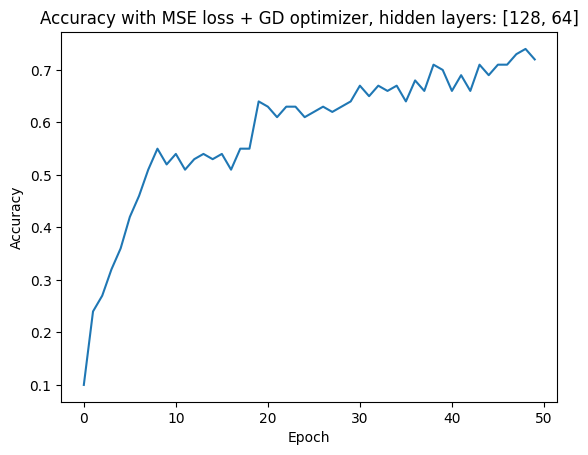

In [ ]:
layers_res_4 = test(MSE, "GD", 0.0084, 50, [128, 64])

[784, 128, 64, 32, 10]


  2%|▏         | 1/50 [00:04<03:34,  4.37s/it]

0.07


  4%|▍         | 2/50 [00:08<03:23,  4.23s/it]

0.25


  6%|▌         | 3/50 [00:12<03:14,  4.15s/it]

0.31


  8%|▊         | 4/50 [00:16<03:12,  4.19s/it]

0.3


 10%|█         | 5/50 [00:20<03:07,  4.17s/it]

0.36


 12%|█▏        | 6/50 [00:24<03:01,  4.13s/it]

0.36


 14%|█▍        | 7/50 [00:29<02:58,  4.15s/it]

0.4


 16%|█▌        | 8/50 [00:33<02:54,  4.16s/it]

0.39


 18%|█▊        | 9/50 [00:37<02:54,  4.26s/it]

0.4


 20%|██        | 10/50 [00:42<02:57,  4.45s/it]

0.38


 22%|██▏       | 11/50 [00:47<02:56,  4.53s/it]

0.43


 24%|██▍       | 12/50 [00:51<02:50,  4.50s/it]

0.47


 26%|██▌       | 13/50 [00:56<02:48,  4.54s/it]

0.52


 28%|██▊       | 14/50 [01:01<02:44,  4.57s/it]

0.55


 30%|███       | 15/50 [01:08<03:04,  5.27s/it]

0.54


 32%|███▏      | 16/50 [01:12<02:53,  5.11s/it]

0.51


 34%|███▍      | 17/50 [01:17<02:46,  5.05s/it]

0.58


 36%|███▌      | 18/50 [01:22<02:41,  5.05s/it]

0.53


 38%|███▊      | 19/50 [01:27<02:36,  5.06s/it]

0.54


 40%|████      | 20/50 [01:32<02:31,  5.06s/it]

0.6


 42%|████▏     | 21/50 [01:37<02:26,  5.05s/it]

0.6


 44%|████▍     | 22/50 [01:43<02:23,  5.14s/it]

0.58


 46%|████▌     | 23/50 [01:48<02:18,  5.14s/it]

0.61


 48%|████▊     | 24/50 [01:53<02:13,  5.15s/it]

0.59


 50%|█████     | 25/50 [01:58<02:09,  5.19s/it]

0.59


 52%|█████▏    | 26/50 [02:04<02:11,  5.47s/it]

0.6


 54%|█████▍    | 27/50 [02:10<02:04,  5.40s/it]

0.59


 56%|█████▌    | 28/50 [02:15<01:59,  5.43s/it]

0.58


 58%|█████▊    | 29/50 [02:21<01:54,  5.44s/it]

0.58


 60%|██████    | 30/50 [02:27<01:55,  5.77s/it]

0.61


 62%|██████▏   | 31/50 [02:33<01:51,  5.87s/it]

0.52


 64%|██████▍   | 32/50 [02:40<01:48,  6.02s/it]

0.6


 66%|██████▌   | 33/50 [02:46<01:43,  6.07s/it]

0.63


 68%|██████▊   | 34/50 [02:53<01:42,  6.41s/it]

0.66


 70%|███████   | 35/50 [03:00<01:37,  6.50s/it]

0.69


 72%|███████▏  | 36/50 [03:06<01:29,  6.41s/it]

0.74


 74%|███████▍  | 37/50 [03:13<01:24,  6.46s/it]

0.73


 76%|███████▌  | 38/50 [03:19<01:17,  6.49s/it]

0.74


 78%|███████▊  | 39/50 [03:25<01:10,  6.44s/it]

0.71


 80%|████████  | 40/50 [03:32<01:03,  6.37s/it]

0.69


 82%|████████▏ | 41/50 [03:38<00:58,  6.46s/it]

0.73


 84%|████████▍ | 42/50 [03:45<00:52,  6.61s/it]

0.71


 86%|████████▌ | 43/50 [03:52<00:46,  6.67s/it]

0.72


 88%|████████▊ | 44/50 [03:59<00:40,  6.71s/it]

0.71


 90%|█████████ | 45/50 [04:05<00:32,  6.52s/it]

0.76


 92%|█████████▏| 46/50 [04:11<00:25,  6.37s/it]

0.72


 94%|█████████▍| 47/50 [04:17<00:18,  6.31s/it]

0.7


 96%|█████████▌| 48/50 [04:23<00:12,  6.21s/it]

0.68


 98%|█████████▊| 49/50 [04:29<00:06,  6.09s/it]

0.71


100%|██████████| 50/50 [04:35<00:00,  5.51s/it]

0.74


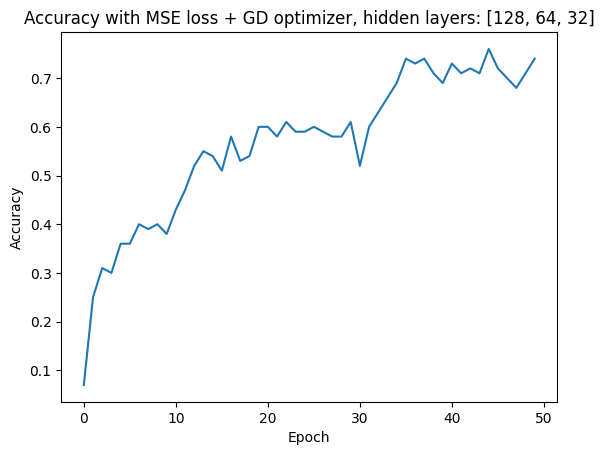

In [ ]:
layers_res_5 = test(MSE, "GD", 0.0098, 50, [128, 64, 32])

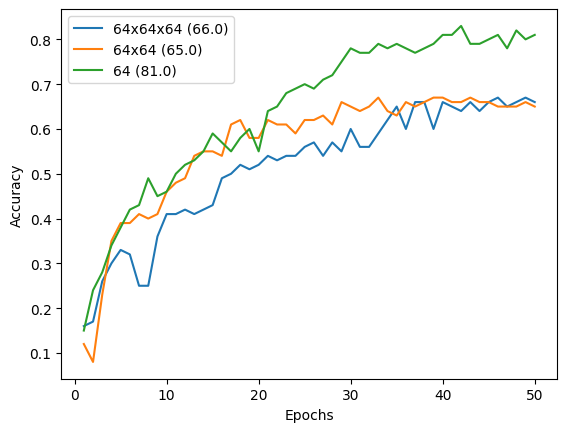

In [ ]:
plt.plot(range(1, 51), layers_res_1, label=f"64x64x64 ({np.round(layers_res_1[-1] * 100, 2)})")
plt.plot(range(1, 51), layers_res_2, label=f"64x64 ({np.round(layers_res_2[-1] * 100, 2)})")
plt.plot(range(1, 51), layers_res_3, label=f"64 ({np.round(layers_res_3[-1] * 100, 2)})")

plt.title('Testing different layer sizes №1 (MSE loss and GD used)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

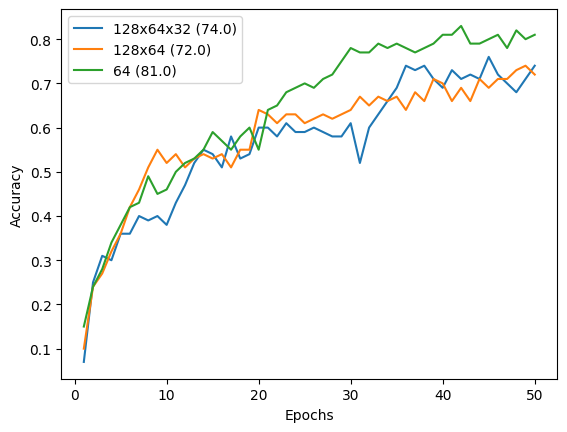

In [ ]:
plt.plot(range(1, 51), layers_res_5, label=f"128x64x32 ({np.round(layers_res_5[-1] * 100, 2)})")
plt.plot(range(1, 51), layers_res_4, label=f"128x64 ({np.round(layers_res_4[-1] * 100, 2)})")
plt.plot(range(1, 51), layers_res_3, label=f"64 ({np.round(layers_res_3[-1] * 100, 2)})")

plt.title('Testing different layer №2 (MSE loss and GD used)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()